# Robust Spectrogram with Iteratively Reweighted Least Squares

Adam Li

Reference: Ba, D., Babadi, B., Purdon, P. L., & Brown, E. N. (2014). Robust spectrotemporal decomposition by iteratively reweighted least squares. Proceedings of the National Academy of Sciences, 111(50), E5336-E5345.

In [1]:
# Import Necessary Libraries
import numpy as np
import scipy as sp

import matplotlib
# from matplotlib import *
from matplotlib import pyplot as plt

# pretty charting
import seaborn as sns
sns.set_palette('muted')
sns.set_style('darkgrid')

%matplotlib inline

## Toy Example From Reference

This example points out the limitations of classical techniques in analyzing time series data.  We simulated noisy observations from the linear combination of two amplitude-modulated signals using the following equation:

$y_{t}=10 \cos^{8}\left(2\pi f_{o}t\right) \sin\left(2\pi f_{1}t\right)+10\exp\left(4\frac{t-T}{T}\right)\cos\left(2\pi f_{2}t\right)+v_{t}, \quad$ for $\enspace 0\leq t \leq T$

where $f_{0}=0.04$ Hz, $f_{1}=10$ Hz, $f_{2}=11$ Hz, $T=600$ s, and $\left(v_{t}\right)_{t=1}^{T}$ is independent, identically distributed, zero-mean Gaussian noise with variance set to acheive a signal-to-noise ratio (SNR) of 5 dB.

The simulated data consists of a 10 Hz oscillation whos amplitude is modulated by  slow 0.04 Hz oscillation, and an exponentially gorwing 11 Hz oscillation.


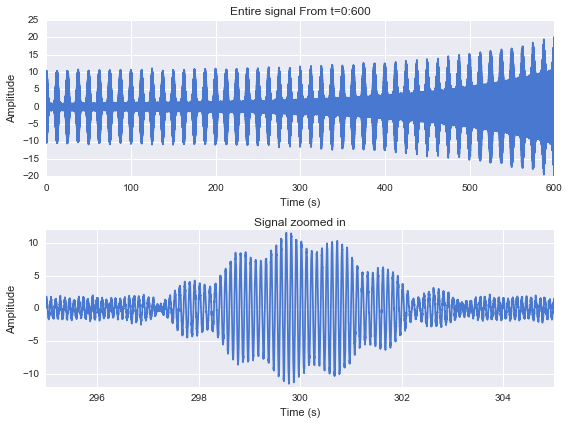

In [2]:
T = 600  # overall time length of simulation (600 sec)
fs = 500 # assumed sampling freq
f0 = 0.04
f1 = 10
f2 = 11

# generate dynamically noisy signal
t = np.linspace(0, T, fs*T) # generate time vector sample points
noise = np.random.normal(0, 0.3, T*fs)
signal = 10*np.cos(2*np.pi*f0*t)**8 * np.sin(2*np.pi*f1*t) + \
    10*np.exp(4*(t-T)/T)*np.cos(2*np.pi*f2*t) + noise
    
## plot
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(8,6))
ax[0].plot(t,signal)
ax[0].set_ylabel('Amplitude')
ax[0].set_xlabel('Time (s)')
ax[0].set_title('Entire signal From t=0:600')

ax[1].plot(t,signal)
ax[1].set_ylabel('Amplitude')
ax[1].set_xlabel('Time (s)')
ax[1].set_title('Signal zoomed in')
ax[1].set_xlim([295,305])
ax[1].set_ylim([-12,12])
fig.tight_layout()

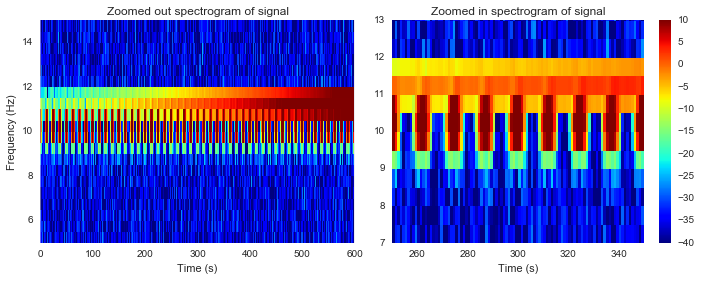

In [22]:
# REGULAR SPECTROGRAM WITH 2 second window, 1 second overlap
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))

im1 = ax[0].specgram(signal, NFFT=1000, Fs=500, noverlap=500, interpolation='none', cmap='jet', aspect='auto')
ax[0].set_ylim([5,15])
ax[0].set_ylabel('Frequency (Hz)')
ax[0].set_xlabel('Time (s)')
ax[0].set_title('Zoomed out spectrogram of signal')
ax[0].grid(False)
im1[3].set_clim(-40,10)

im2 = ax[1].specgram(signal,NFFT=1000, Fs=500, noverlap=500, interpolation='none', cmap='jet', aspect='auto')
ax[1].set_xlim([250,350])
ax[1].set_ylim([7,13])
ax[1].set_xlabel('Time (s)')
ax[1].set_title('Zoomed in spectrogram of signal')
ax[1].grid(False)
fig.tight_layout()
im2[3].set_clim(-40,10)
cb = fig.colorbar(im2[3])

## Robust Spectral Decomposition

### The State-Space Model

In this analysis, we will consider a signal $y_{t}$ that is obtained by sampling a noisy, continuous-time signal at rate $f_{s}$ (above the Nyquist rate).

* $y_{t}\rightarrow$ discrete-time signal
* $t = 1,2,...,T\rightarrow$ samples
* $f_{s}\rightarrow$ sampling rate
* $W\rightarrow$ arbitrary window length
* $N \triangleq \frac{T}{W}\rightarrow$ number of windows
* $y_{n} \triangleq \left(y_{\left(n-1\right)W+1},y_{\left(n-1\right)W+2},...,y_{nW}\right)'$ for $n=1,2,...,N$

Consider the following spectrotemporal representation of $y_{n}$ as:

$$y_{n} = \tilde{F}_{n}\tilde{x}_{n} + v_{n}$$
where,
* $\left ( \tilde{F}_{n} \right )_{l,k} \triangleq \exp \left( j2\pi \left( \left(n-1 \right) W+l \right) \frac{\left( k-1 \right)}{K} \right)$
for $l=1,2,...,W$ and $k=1,2,...K$
* $\tilde{x}_{n} \triangleq \left(\tilde{x}_{n,1},\tilde{x}_{n,2},...,\tilde{x}_{n,K} \right)' $
* $v_{n}\rightarrow$ independent, identically distributed, additive zero-mean Gaussian noise

Fn here is like a Fourier transform.

The following is like a typical Kalman filter forward model. Equivalently, we can define the linear observation model over a real vector space as follows:

$$y_{n} = F_{n}x_{n}+v_{n}$$
where,
* $\left ( F_{n} \right )_{l,k} \triangleq \cos \left( 2\pi \left( \left(n-1 \right) W+l \right) \frac{\left( k-1 \right)}{K} \right)$ for $l = 1,2,...,W$ and $k=1,2,...\frac{K}{2}$
* $\left ( F_{n} \right )_{l,k+K/2} \triangleq \sin \left( 2\pi \left( \left(n-1 \right) W+l \right) \frac{\left( k-1 \right)}{K} \right)$ for $l = 1,2,...,W$ and $k=1,2,...\frac{K}{2}$
* $x_{n} \triangleq \left(x_{n,1},x_{n,2},...,x_{n,K} \right)' $


**Algorithm:**

Initial Conditions: 

* $x_{0\mid 0} = \left(0,...,0\right)' \in \mathbb{R}^{K}$
* $\Sigma_{0\mid 0} = I_{k} \in \mathbb{R}^{KxK}$

Filter at time $n=1,2,...,N$:
* $x_{n\mid n-1}=x_{n-1 \mid n-1}$
* $\Sigma_{n\mid n-1}=\Sigma_{n-1\mid n-1}+Q^{\left(l\right)}$
* $K_{n}=\Sigma_{n\mid n-1}F_{n}^{H}\left(F_{n}\Sigma_{n\mid n-1}F_{n}^{H}+\sigma^{2}I\right)^{-1}$
* $x_{n\mid n}=x_{n\mid n-1}+K_{n}\left(y_{n}-F_{n}x_{n\mid n-1}\right)$
* $\Sigma_{n\mid n}=\Sigma_{n\mid n-1}-K_{n}F_{n}\Sigma_{n\mid n-1}$

(1000, 1000)


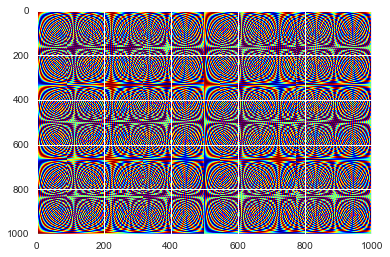

In [10]:
## Initialize parameters
numSamples = fs*T
W = 1000 # window size of 1 second
K = W    # indice over freq. bands
N = numSamples//W # number of windows along signal

F = np.zeros((K,K))
k = np.array(range(1, K//2+1))
l = np.array(range(1, W+1))

# Fourier along 1000 time points and 1000 frequency points
for ii in range(0, k.size):
    for jj in range(0, l.size):
        F[jj, ii] = np.cos(2*np.pi*l[jj] * (k[ii]-1)/K)
        F[jj, ii+K//2] = np.sin(2*np.pi *l[jj] * (k[ii]-1)/K)

plt.imshow(F, interpolation='none', cmap='jet', aspect='auto')
print F.shape

In [3]:
# Returns: xEst, freq, time, numIter
# data: 1D time series vector
#
def robustSpectrogram(data, fs, window, alpha, tol=0.005, maxIter=30):
    ## Initialize parameters
    numSamples = len(data)
    W = window # window size of 1 second
    K = W    # indice over freq. bands
    N = numSamples//W # number of windows along signal time

    F = np.zeros((K,K))
    Q = np.eye(K) * 0.001
    signal = data
    
    # Fourier along 1000 time points and 1000 frequency points
#     for l in range(0, W):
#         for k in range(0, K//2):
#             F[l,k] = np.cos(2*np.pi*l*(k-1)/K)
#             F[l,k+K//2] = np.sin(2*np.pi*l * (k-1)/K)
            
    F = np.zeros([W,K])
    k = np.array(range(1,K//2+1))
    l = np.array(range(1,W+1))

    for jj in range(0,np.size(k)):
        for ii in range(0,np.size(l)):                      
            F[ii,jj]      = np.cos(2*np.pi*l[ii]*(k[jj]-1)/K)
            F[ii,jj+K//2] = np.sin(2*np.pi*l[ii]*(k[jj]-1)/K)
            
    # run iterations
    numIter = 1
    while(numIter <= maxIter):
        ## Initialize and Kalman Filter
        xPrior = np.zeros((K,N+1))     # x(n+1|n)
        xPosterior = np.zeros((K,N+1)) # x(n|n)
        pPrior = np.zeros((K,K,N+1))   # p(n+1|n)
        pPosterior = np.zeros((K,K,N+1)) # p(n|n)
        pPrior[:,:,0] = np.eye(K) # set initial priors to have variance of 1, cov = 0

        ## Step 1: Kalman Filter
        for n in range(0, N):
            y = signal[n*W:(n+1)*W]
            
            ## 01: Update priors
            xPrior[:,n+1] = xPosterior[:,n]
            pPrior[:,:,n+1] = pPosterior[:,:,n] + Q
            
            ## 02: Compute Kalman gain
            kGain = np.dot(pPrior[:,:,n+1], F.T).dot(np.linalg.inv(np.dot(F,pPrior[:,:,n+1]).dot(F.T) + np.eye(K)))
            
            ## 03: Compute Posteriors
            xPosterior[:,n+1] = xPrior[:,n+1] + np.dot(kGain, y-np.dot(F,xPrior[:,n+1]))
            pPosterior[:,:,n+1] = pPrior[:,:,n+1] - np.dot(kGain, F).dot(pPrior[:,:,n+1])
        
        
        ## Remove initial conditions
        xPrior = xPrior[:,1:N+1]
        xPosterior = xPosterior[:, 1:N+1]
        pPrior = pPrior[:,:,1:N+1]
        pPosterior = pPosterior[:,:,1:N+1]
        
        ## Step 2: Kalman Smoother
        xSmooth = xPrior
        pSmooth = pPrior
        
        for n in range(N-2,-1,-1):
            # compute Kalman gain smoother
            B = np.dot(pPosterior[:,:,n], np.linalg.inv(pPrior[:,:,n+1]))
            xSmooth[:,n] = xPrior[:,n] + np.dot(B, (xSmooth[:,n+1] - xPrior[:,n+1]))
            pSmooth[:,:,n] = pPosterior[:,:,n] + np.dot(B, (pSmooth[:,:,n+1] - pPrior[:,:,n+1]).dot(B.T))
            
        ## Step 3: Check Breakpoint
        if numIter > 1 and np.linalg.norm(xSmooth-xPrev, 'fro')/np.linalg.norm(xPrev,'fro') < tol:
            break
            
        ## Step 4: Update Q
        Q = np.zeros((K,K))
        for k in range(0, K):
            qTemp = 0
            # perform summation of adjacent state's squared error
            for n in range(1, N):
                qTemp += (xSmooth[k,n] - xSmooth[k,n-1])**2
            Q[k,k] = ((qTemp + np.finfo(float).eps**2)**(1/2)) / alpha
        
        xPrev = xSmooth
        numIter += 1
        print "iteration: ", numIter
        
    xEst = xSmooth[0:K//2,:] - xSmooth[K//2:W,:]*1j
    freq = np.arange(0, K//2, 1.)*fs/K + 1 # frequency to half of sampling freq
    time = np.arange(0, N)*W/fs
    
    return xEst, freq, time, numIter

In [5]:
## IRLS Algorithm
# parameters
alpha = 100
tol = 0.005
maxIter = 30

W = 1000 # window size of 1 second

In [25]:
#Parameters
alpha = 40000
tol = 0.005
maxIter = 10
data = signal[0:100000]
fs = 500
window = W

print data.shape


(100000,)


In [26]:
xEst, freq, time, numIter = robustSpectrogram(data, fs, window, alpha, tol, maxIter)

print xEst.shape
print freq.shape
print time.shape
print numIter

iteration:  2
iteration:  3
(500, 100)
(500,)
(100,)
3


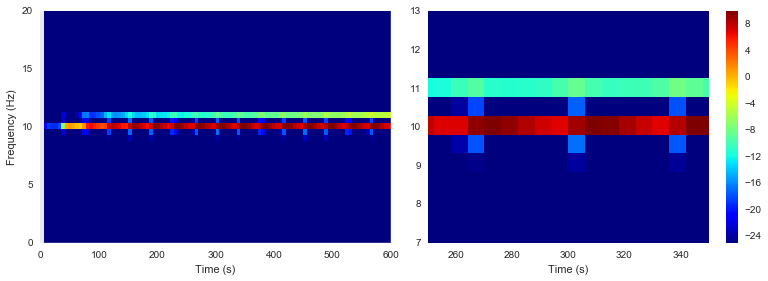

In [27]:
## plotting
xPSD = 10*np.log10(np.abs(xEst)**2)

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(11,4))

im1 = ax[0].imshow(xPSD,origin='lower',extent=[0,N*W//fs,0,fs//2-5],aspect='auto',interpolation='none', cmap='jet')
ax[0].set_ylim([0,20])
ax[0].set_ylabel('Frequency (Hz)')
ax[0].set_xlabel('Time (s)')
ax[0].grid(False)
im1.set_clim(-25,10)

im2 = ax[1].imshow(xPSD,origin='lower',extent=[0,N*W//fs,0,fs//2-5],aspect='auto',interpolation='none', cmap='jet')
ax[1].set_xlim([250,350])
ax[1].set_ylim([7,13])
ax[1].set_xlabel('Time (s)')
ax[1].grid(False)
fig.tight_layout()
im2.set_clim(-25,10)
cb = fig.colorbar(im2)

# Discussion:

The above implements the robust spectrogram on an example from the reference paper. I implement it in a Python and Matlab function for modular calling. 

Pros:
1. denoised freq domain and temporal smoothness

Cons:
1. long computation time